In [662]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for tensorflow-gpu
Failed to build tensorflow-gpu
  Running setup.py install for tensorflow-gpu: started
  Running setup.py install for tensorflow-gpu: finished with status 'error'


  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [18 lines of output]
  Traceback (most recent call last):
    File "<string>", line 2, in <module>
    File "<pip-setuptools-caller>", line 34, in <module>
    File "C:\Users\user\AppData\Local\Temp\pip-install-tggf_e_u\tensorflow-gpu_cac465ff98174002b0f7ccac318f2c20\setup.py", line 37, in <module>
      raise Exception(TF_REMOVAL_WARNING)
  Exception:
  
  The "tensorflow-gpu" package has been removed!
  
  Please install "tensorflow" instead.
  
  Other than the name, the two packages have been identical
  since TensorFlow 2.1, or roughly since Sep 2019. For more
  information, see: pypi.org/project/tensorflow-gpu
  
  
  [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tensorflow-gpu
  error: subprocess-exited-with-error
  
  Running setup.py install for tensorflow-gpu did not 

In [ ]:
!pip list

In [132]:
import tensorflow as tf
import torch
import keras
from sklearn.datasets import make_circles
import os
import cv2
import imghdr

In [664]:
#prepare the data
data_dir = './data' #The information came from the Kaggle database

In [663]:
os.listdir(os.path.join(data_dir))#Operating system function to check that we linked the correct path to the data folder

['Abstract', 'realism']

In [4]:
import numpy as np
from matplotlib import pyplot as plt

In [665]:
data = tf.keras.utils.image_dataset_from_directory('data')#The function automatically infers the labels from the subdirectory names and loads the images accordingly

Found 5365 files belonging to 2 classes.


In [6]:
data.shuffle

<bound method DatasetV2.shuffle of <BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>>

In [666]:
data_iterator = data.as_numpy_iterator()#creating an iterator from a TensorFlow dataset (data) and converting its elements to NumPy arrays

In [8]:
batch = data_iterator.next()

In [9]:
batch[0][0].shape

(256, 256, 3)

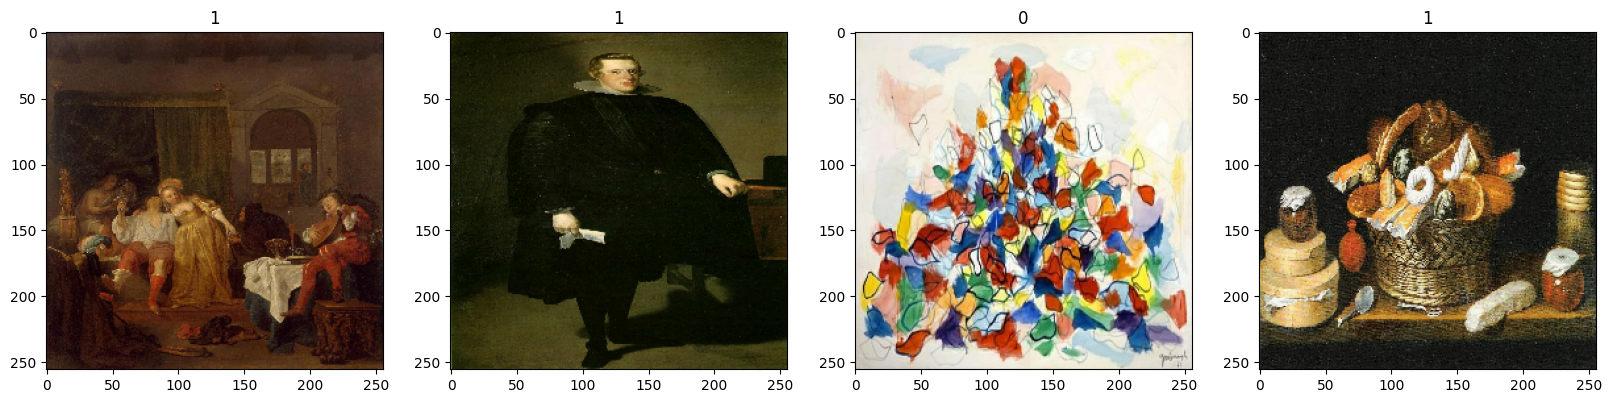

In [10]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [671]:
#x/255, y)`: This expression normalizes the image data (`x`) by dividing it by 255
#This is a common practice in image processing to scale pixel values to the range [0, 1]. The labels (`y`) are left unchanged.
data = data.map(lambda x,y: (x/255, y))

In [672]:
data.as_numpy_iterator().next()

(array([[[[1.21090779e-05, 1.21090779e-05, 1.15059920e-05],
          [1.20871682e-05, 1.20871682e-05, 1.14840823e-05],
          [1.16799674e-05, 1.16799674e-05, 1.10768815e-05],
          ...,
          [1.04451719e-05, 1.02039376e-05, 9.66115931e-06],
          [1.03843922e-05, 1.01431579e-05, 9.60037960e-06],
          [1.03748898e-05, 1.01336555e-05, 9.59087811e-06]],
 
         [[1.28857873e-05, 1.28857873e-05, 1.22827005e-05],
          [1.29139380e-05, 1.29139380e-05, 1.23108521e-05],
          [1.25205170e-05, 1.25205170e-05, 1.19174310e-05],
          ...,
          [1.06517737e-05, 1.04105393e-05, 9.86776195e-06],
          [1.05772151e-05, 1.03359807e-05, 9.79320248e-06],
          [1.04676701e-05, 1.02264357e-05, 9.68365839e-06]],
 
         [[1.32726100e-05, 1.32726100e-05, 1.26695240e-05],
          [1.33007616e-05, 1.33007616e-05, 1.26976756e-05],
          [1.29300752e-05, 1.29300752e-05, 1.23269892e-05],
          ...,
          [1.10349483e-05, 1.07937140e-05, 1.0250

In [273]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [274]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [293]:
from tensorflow.keras import layers, constraints, activations
class Layer_Dense(tf.keras.layers.Layer):
    def __init__(self, output_units, n_neurons):
        super(Layer_Dense, self).__init__()
        self.output_units = output_units
        self.n_neurons = n_neurons
        print(f'n_neurons = {n_neurons}')
        print(f'output_units = {output_units}')
        self.w = self.add_weight(shape=(n_neurons, output_units), initializer="random_normal", trainable = True)
        # self.biases = np.zeros((1, self.output_units))
        self.biases = torch.zeros(self.output_units)

    def call(self, inputs):
        print(f'self.w = {self.w}')
        output = tf.tensordot(inputs, self.w,1) + self.biases
        return output
class Activation_ReLU:
    def forward(self, inputs):
        self.output = np.maximum(0, inputs)

class Activation_Softmax:
    def forward(self, inputs):
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        self.output = probabilities

class Loss:
    def calculate(self, output, y):
        sample_losses = self.forward(output, y)
        data_loss = np.mean(sample_losses)
        return data_loss
    
class Loss_CatergoricalCrossentropy(Loss):
    def forward(self, y_pred, y_true):
        semples = len(y_pred)
        y_pred_clipped = np.clip(y_pred, 1e-7, 1-1e-7)

        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[range(semples), y_true]
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(y_pred_clipped*y_true, axis=1)
        
        megative_log_likeLinhoods = -np.log(correct_confidences)
        return megative_log_likeLinhoods



In [569]:
from tensorflow.keras.layers import Layer
import tensorflow as tf

class CustomNNLayer(tf.keras.layers.Layer):
    def __init__(self, output_units, activation):
        super(CustomNNLayer, self).__init__()
        self.l1 = Layer_Dense(output_units, n_neurons=256)  # Replace 128 with the desired number of neurons
        self.activation = activation
        if activation == 'relu':
            self.activation1 = tf.keras.layers.ReLU()
        elif activation == 'softmax':
            self.activation1 = tf.keras.layers.Softmax()

    def call(self, inputs):
        x = self.l1(inputs)
        if self.activation == 'relu':
            x = self.activation1(x)
        elif self.activation == 'softmax':
            x = self.activation1(x)
        return x

    def get_config(self):
        config = super().get_config()
        config.update({
            "activation": self.activation,
            "activation1": self.activation1
            
        })
        return config

In [570]:
def loss(prediction, label):
    print(prediction[0][0])
    
    print(label[0][0])
    loss = keras.losses.CosineSimilarity(axis=-1, reduction="sum_over_batch_size", name="cosine_similarity")
    #loss -sum(l2_norm(label) * l2_norm(prediction))
    return loss

In [571]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
import pandas as pd

In [572]:
model = Sequential()

In [573]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(units=256, activation='relu'))
# Apply your custom layer
model.add(CustomNNLayer(output_units=256, activation='relu'))
#model.add(CustomNNLayer(output_units=32, activation='relu'))
#model.add(Dense(units=2, activation='softmax'))
#model.add(CustomNNLayer(output_units=2, activation='softmax'))
#model.add(Dense(1, activation='softmax'))
model.add(Dense(1, activation='sigmoid'))

n_neurons = 256
output_units = 256
self.w = <tf.Variable 'Variable:0' shape=(256, 256) dtype=float32>


In [574]:
model.compile(optimizer='Adam', loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [575]:
model.summary()

Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_201 (Conv2D)         (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_186 (MaxPooli  (None, 127, 127, 16)     0         
 ng2D)                                                           
                                                                 
 conv2d_202 (Conv2D)         (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_187 (MaxPooli  (None, 62, 62, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_203 (Conv2D)         (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_188 (MaxPooli  (None, 30, 30, 16)     

In [576]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [579]:
hist = model.fit(train, epochs=12, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/12
117/117 [==============================] - 355s 3s/step - loss: 0.1530 - accuracy: 0.9439 - val_loss: 0.1504 - val_accuracy: 0.9432
Epoch 2/12
117/117 [==============================] - 347s 3s/step - loss: 0.1242 - accuracy: 0.9506 - val_loss: 0.1388 - val_accuracy: 0.9432
Epoch 3/12
117/117 [==============================] - 351s 3s/step - loss: 0.0980 - accuracy: 0.9647 - val_loss: 0.1495 - val_accuracy: 0.9470
Epoch 4/12
117/117 [==============================] - 353s 3s/step - loss: 0.0862 - accuracy: 0.9722 - val_loss: 0.1617 - val_accuracy: 0.9451
Epoch 5/12
117/117 [==============================] - 353s 3s/step - loss: 0.0741 - accuracy: 0.9722 - val_loss: 0.1484 - val_accuracy: 0.9451
Epoch 6/12
117/117 [==============================] - 357s 3s/step - loss: 0.0458 - accuracy: 0.9832 - val_loss: 0.1381 - val_accuracy: 0.9498
Epoch 7/12
117/117 [==============================] - 360s 3s/step - loss: 0.0359 - accuracy: 0.9893 - val_loss: 0.2329 - val_accuracy: 0.9422

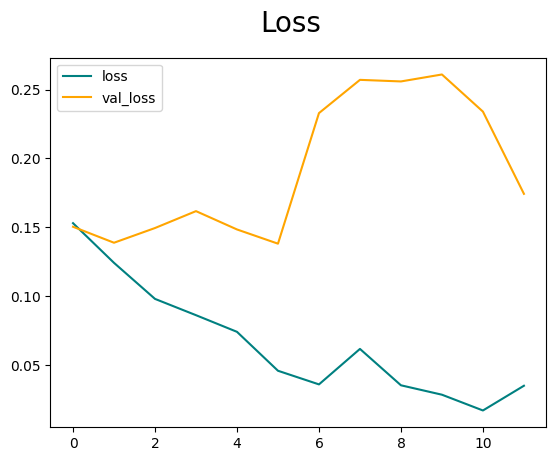

In [580]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

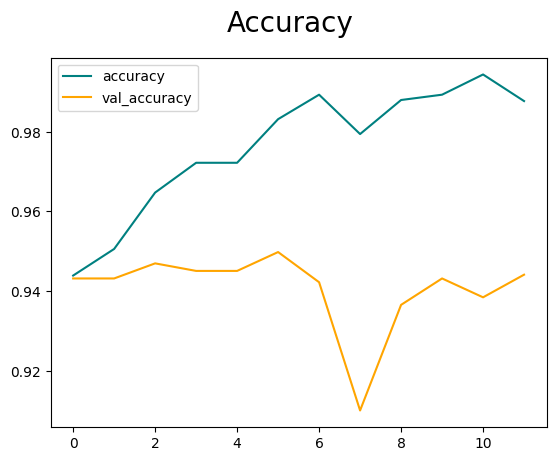

In [581]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [582]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [583]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [584]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

self.w = <tf.Variable 'Variable:0' shape=(256, 256) dtype=float32>
1/1 [==============================] - 0s 425ms/step


In [585]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.95539033, shape=(), dtype=float32) tf.Tensor(0.9589552, shape=(), dtype=float32) tf.Tensor(0.9550781, shape=(), dtype=float32)


In [586]:
import cv2

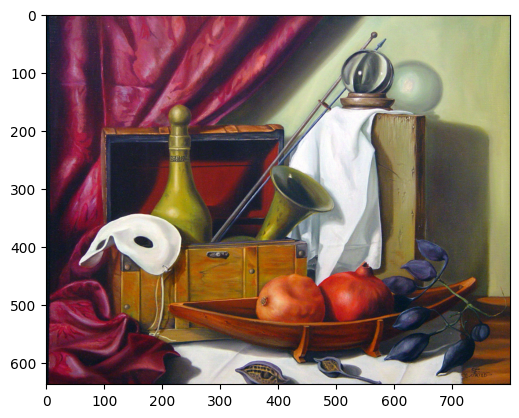

In [635]:
img = cv2.imread('realism5.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

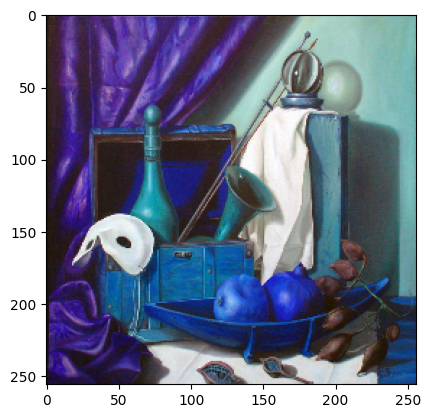

In [636]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [640]:
np.expand_dims(resize, 0).shape

(1, 256, 256, 3)

In [646]:
newImg = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 53ms/step


In [649]:
newImg

array([[2.6250686e-07]], dtype=float32)

In [658]:
if newImg > 0.05: 
    print(f'Predicted class is rializem')
else:
    print(f'Predicted class is Abstract')

Predicted class is Abstract
